In [2]:
# basic libraries
import math
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# torch libraries
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch import nn
from torch_snippets import Report
from torchsummary import summary

from sklearn.metrics import cohen_kappa_score


/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
root_path = "images_mo434/"


# Preparing dataset

Falta criar o dataset de par

In [4]:
fish_path = "old_fish/"
fish_path
img_paths = [fish_path+x for x in os.listdir(fish_path)]

In [5]:
# originally images have 1024x768
xsize = 224 # pixels
ysize = 224
nchannels = 3
maxval = 255 # pixel value

# percentages of samples to split
train_perc = 0.3
valid_perc = 0.3
test_perc = 0.4

In [6]:
num_train_samples = int(len(img_paths)*train_perc)
num_valid_samples = int(len(img_paths)*valid_perc)
num_test_samples = int(len(img_paths)*test_perc)

np.random.shuffle(img_paths)

train_set = img_paths[:num_train_samples]
valid_set = img_paths[num_train_samples:num_train_samples+num_valid_samples]
test_set = img_paths[num_train_samples+num_valid_samples:]

In [7]:
# rgb_values = np.concatenate(
#     [Image.open(img).getdata() for img in img_paths], 
#     axis=0
# ) / 255.

# mean_val_pixel = np.mean(rgb_values, axis=0)  # mu_rgb.shape == (3,)
# std_val_pixel = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)

#calculate this takes too long, so I wrote the result here:
mean_val_pixels = (0.420,0.424,0.460)
std_val_pixels = (0.230, 0.174 ,0.160)


print(f"Mean value of pixels: {mean_val_pixels}\nStandard deviation of pixels values: {std_val_pixels}")

Mean value of pixels: (0.42, 0.424, 0.46)
Standard deviation of pixels values: (0.23, 0.174, 0.16)


In [8]:
# defining device
gpu = torch.cuda.is_available()
device = torch.device(0) if gpu else torch.device('cpu')

In [9]:
class ImageDataSet():

    def __init__(self, dataset, transform=None):
        self.dataset = dataset # list of image paths
        self.targets = [int(str(x).split("/")[-1].split("_")[0]) for x in self.dataset]
        self.transform = transform

    def __len__(self): 
        return len(self.dataset)

    def __getitem__(self, ix): #ix is the position
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image, target)


In [10]:

# Defining preprocessing transforms
prep = transforms.Compose([
    transforms.Resize((xsize, ysize), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean_val_pixels, std_val_pixels) # mean, std
])

# Defining data augmentation to be implemented during training
aug  = transforms.Compose([
    transforms.Resize((600,400), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(500),
    transforms.Resize((xsize,ysize), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean_val_pixels, std_val_pixels)
])

In [11]:
def GetBatches(dataset, batchsize, transformation):
    datatensor = ImageDataSet(dataset, transformation)
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return dataloader

In [12]:
batchsize = 30

trainload = GetBatches(train_set, batchsize, aug)  
validload = GetBatches(valid_set, batchsize, prep)
testload  = GetBatches(test_set, batchsize, prep) 

# Pretrained models

In [13]:
# train and val functions

def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()

def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc = 0
    for bx, data in enumerate(testload):
        loss, acc = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc += acc

    mean_loss = mean_loss/N
    mean_acc = mean_acc/N
    return (mean_loss, mean_acc)


In [14]:
nclasses = 9

In [15]:
# define same criterion for all

def Criterion(preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    #compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] #same as argmax
    acc = torch.sum(pred_labels==targets.data) / pred_labels.size(0)
    return loss, acc

# VGG

In [21]:
# Network architecture
def CorelVGG(nclasses):
    #get the vgg16 model pretrained on ImageNet
    model = models.vgg16(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = True

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, nclasses)
                                     )
    criterion = Criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return (model.to(device), criterion, optimizer)

model_vgg, criterion_vgg, optimizer_vgg = CorelVGG(nclasses)

In [17]:
# model's architecture
# summary(model_vgg, (nchannels, ysize, xsize))

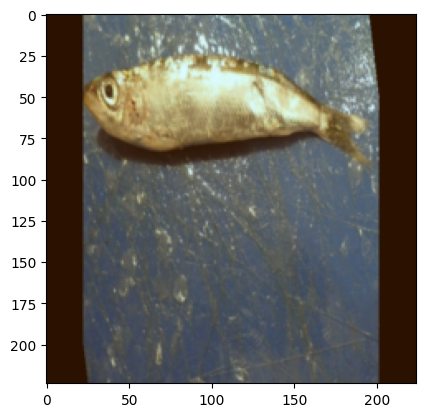

In [18]:
#trying to visualize one image:
img, target = ImageDataSet(train_set, aug)[0]
img = img.permute(1,2,0).numpy()
img = 255*(img - np.min(img))/(np.max(img)-np.min(img))
img = img.astype('uint8')
plt.imshow(img)
plt.show()


In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
# Train and evaluate
n_epochs = 50
log = Report(n_epochs)

print("VGG")
for epoch in range(n_epochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        loss, acc = train_batch(model_vgg, data, optimizer_vgg, criterion_vgg, device)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    for i, data in enumerate(validload):
        loss, acc = train_batch(model_vgg, data, optimizer_vgg, criterion_vgg, device)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

VGG
EPOCH: 20.000  trn_acc: 0.269  val_loss: 2.027  val_acc: 0.196  trn_loss: 2.158  (2368.85s - 3553.28s remaining)
EPOCH: 40.000  trn_acc: 0.462  val_loss: 1.105  val_acc: 0.531  trn_loss: 1.292  (5638.25s - 1409.56s remaining)
EPOCH: 50.000  val_loss: 0.480  val_acc: 0.889  (7195.01s - 0.00s remaining))))

100%|██████████| 151/151 [00:00<00:00, 2856.72it/s]


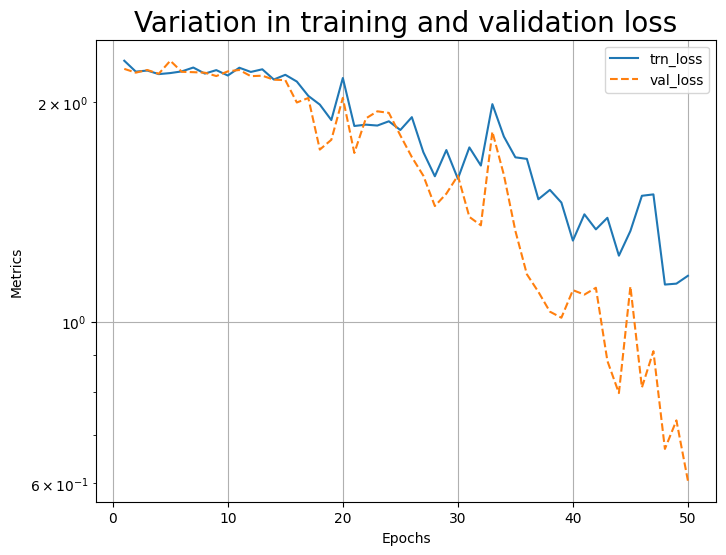

100%|██████████| 151/151 [00:00<00:00, 7385.29it/s]


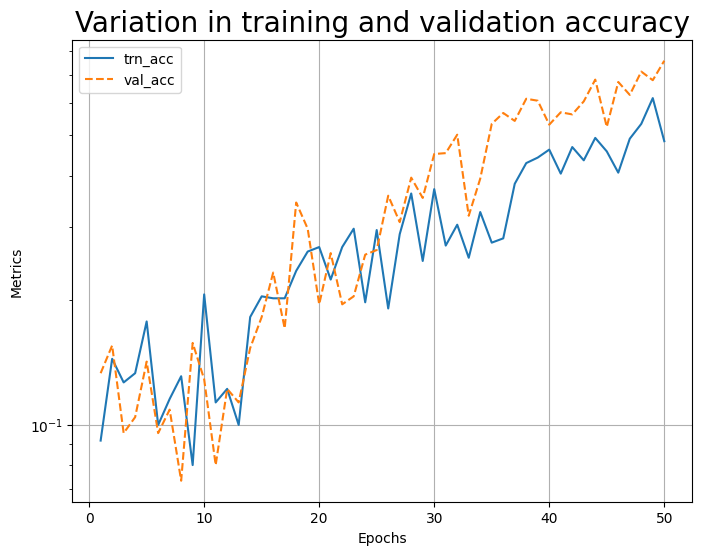

In [23]:
# plotting results 
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title="Variation in training and validation loss")
log.plot_epochs(['trn_acc', 'val_acc'], log=True, title="Variation in training and validation accuracy")

In [24]:
# testing on test set 
loss, acc = Test(model_vgg, testload, Criterion, device)
print(f"Loss: {loss:.6f} \nAcc:{acc:.6f}")

Loss: 1.371069 
Acc:0.507576


# RESNET

In [25]:
# Network architecture

def CorelResNet(nclasses):

    model = models.resnet34(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = True

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, nclasses)
                                     )
    criterion = Criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return (model.to(device), criterion, optimizer)

model_resnet, criterion_resnet, optimizer_resnet = CorelResNet(nclasses)

In [26]:
# model's architecture
summary(model_resnet, (nchannels, ysize, xsize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
# Train and evaluate
n_epochs = 50
log = Report(n_epochs)

print("RESNET")
for epoch in range(n_epochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        loss, acc = train_batch(model_resnet, data, optimizer_resnet, criterion_resnet, device)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    for i, data in enumerate(validload):
        loss, acc = train_batch(model_resnet, data, optimizer_resnet, criterion_resnet, device)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

RESNET
EPOCH: 20.000  trn_acc: 1.000  val_loss: 0.008  val_acc: 1.000  trn_loss: 0.012  (1074.87s - 1612.30s remaining)
EPOCH: 40.000  trn_acc: 1.000  val_loss: 0.010  val_acc: 1.000  trn_loss: 0.028  (1933.08s - 483.27s remaining)
EPOCH: 50.000  val_loss: 0.004  val_acc: 1.000  (2364.92s - 0.00s remaining)))

  0%|          | 0/151 [00:00<?, ?it/s]

100%|██████████| 151/151 [00:00<00:00, 7208.27it/s]


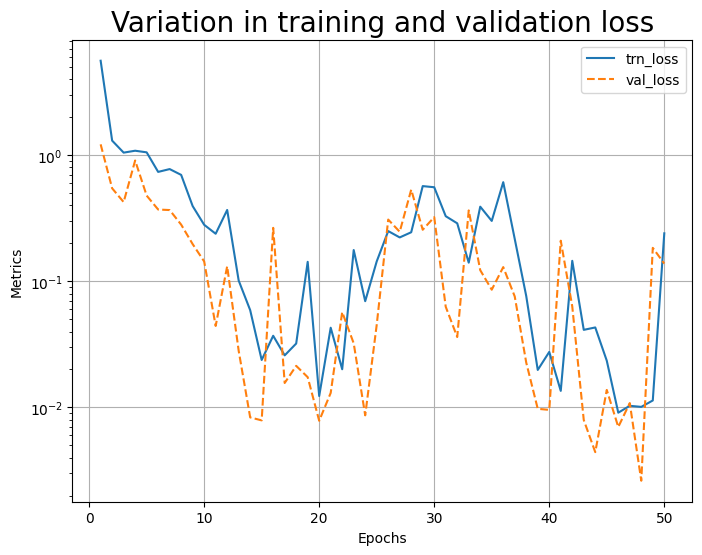

100%|██████████| 151/151 [00:00<00:00, 12310.53it/s]


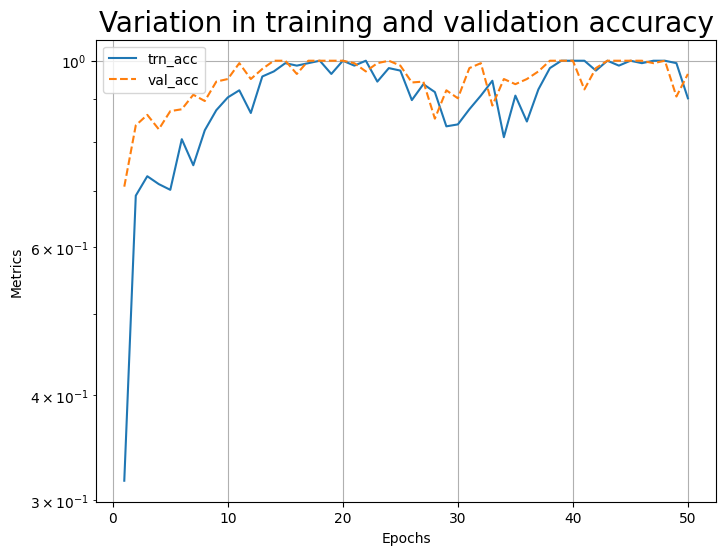

In [28]:
# plotting results 
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title="Variation in training and validation loss")
log.plot_epochs(['trn_acc', 'val_acc'], log=True, title="Variation in training and validation accuracy")

# DENSENET

In [45]:
def CorelDenseNet(nclasses):

    model = models.densenet201(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = True

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(1920, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, nclasses)
                                     )
    criterion = Criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return (model.to(device), criterion, optimizer)

model_densenet, criterion_densenet, optimizer_densenet = CorelDenseNet(nclasses)

In [46]:
# model's architecture
# summary(model_densenet, (nchannels, ysize, xsize))

In [47]:
# Train and evaluate
n_epochs = 50
log = Report(n_epochs)

print("DENSENET")
for epoch in range(n_epochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        loss, acc = train_batch(model_densenet, data, optimizer_densenet, criterion_densenet, device)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    for i, data in enumerate(validload):
        loss, acc = train_batch(model_densenet, data, optimizer_densenet, criterion_densenet,device)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

DENSENET
EPOCH: 20.000  trn_acc: 0.929  val_loss: 0.270  val_acc: 0.951  trn_loss: 0.140  (2230.45s - 3345.67s remaining)
EPOCH: 40.000  trn_acc: 0.931  val_loss: 0.039  val_acc: 0.993  trn_loss: 0.151  (4746.85s - 1186.71s remaining)
EPOCH: 50.000  val_loss: 0.426  val_acc: 0.889  (6171.90s - 0.00s remaining))))

100%|██████████| 151/151 [00:00<00:00, 9566.78it/s]


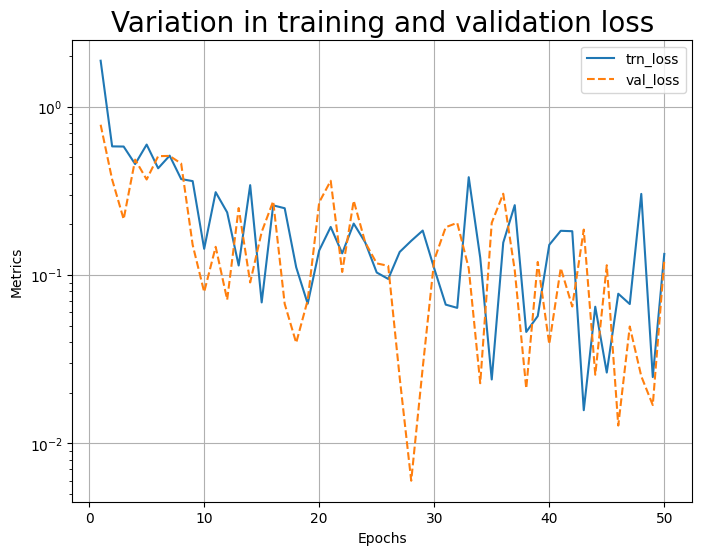

100%|██████████| 151/151 [00:00<00:00, 9227.52it/s]


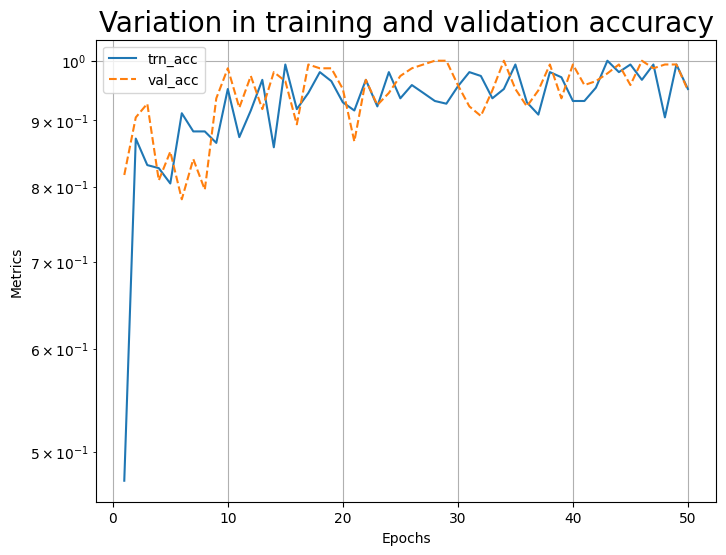

In [48]:
# plotting results 
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title="Variation in training and validation loss")
log.plot_epochs(['trn_acc', 'val_acc'], log=True, title="Variation in training and validation accuracy")

# Testing models (metrics)

In [33]:
# MELHOR TESTAR INPUTANDO SÓ UMA CLASSE
import pandas as pd

testset0 = [x for x in test_set if "000_" in x]
testload0  = GetBatches(testset0, batchsize, prep) 
testset1 = [x for x in test_set if "001_" in x]
testload1  = GetBatches(testset1, batchsize, prep) 
testset2 = [x for x in test_set if "002_" in x]
testload2  = GetBatches(testset2, batchsize, prep) 
testset3 = [x for x in test_set if "003_" in x]
testload3  = GetBatches(testset3, batchsize, prep) 
testset4 = [x for x in test_set if "004_" in x]
testload4  = GetBatches(testset4, batchsize, prep) 
testset5 = [x for x in test_set if "005_" in x]
testload5  = GetBatches(testset5, batchsize, prep) 
testset6 = [x for x in test_set if "006_" in x]
testload6  = GetBatches(testset6, batchsize, prep)
testset7 = [x for x in test_set if "007_" in x]
testload7  = GetBatches(testset7, batchsize, prep) 
testset8 = [x for x in test_set if "008_" in x]
testload8  = GetBatches(testset8, batchsize, prep)

In [34]:
fish_numbers = {
              0:'Black Sea Sprat',
              1:'Gilt-Head Bream', 
              2:'Hourse Mackerel',
              3:'Red Mullet',
              4:'Red Sea Bream', 
              5:'Sea Bass',
              6:'Shrimp',
              7:'Striped Red Mullet',
              8:'Trout'
              }

In [35]:
def Test_per_class(model, testload, device):

    kappa = []
    acc = []

    for _, data in enumerate(testload):
        # take original data
        ims, target = data
        ims = ims.to(device=device)
        target = target.to(device=device)
        # run model to see predicted
        preds = model(ims)
        pred_labels = torch.max(preds, 1)[1] #same as argmax
        # calculate accurancy and cohens kappa
        for val_target, val_pred in zip(target.tolist(),pred_labels.tolist()):
            accur = int(val_target==val_pred)
            acc.append(accur)
            kappa.append(cohen_kappa_score(np.array([val_target]), np.array([val_pred])))
    

    kappa = [1 if math.isnan(x) else x for x in kappa]
    mean_kappa = np.mean(kappa)
    mean_acc = np.mean(acc)
    std_kappa = np.std(kappa)
    std_acc = np.std(acc)

    return ([mean_kappa, std_kappa, mean_acc, std_acc])

## VGG

In [36]:

m0 = Test_per_class(model_vgg, testload0, device)
m1 = Test_per_class(model_vgg, testload1, device)
m2 = Test_per_class(model_vgg, testload2, device)
m3 = Test_per_class(model_vgg, testload3, device)
m4 = Test_per_class(model_vgg, testload4, device)
m5 = Test_per_class(model_vgg, testload5, device)
m6 = Test_per_class(model_vgg, testload6, device)
m7 = Test_per_class(model_vgg, testload7, device)
m8 = Test_per_class(model_vgg, testload8, device)


/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_c

In [37]:

df_metrics = pd.DataFrame(columns=['Mean kappa', 'Std kappa', 'Mean accuracy', 'Std accuracy'])
df_metrics.loc[len(df_metrics)] = m0
df_metrics.loc[len(df_metrics)] = m1
df_metrics.loc[len(df_metrics)] = m2
df_metrics.loc[len(df_metrics)] = m3
df_metrics.loc[len(df_metrics)] = m4
df_metrics.loc[len(df_metrics)] = m5
df_metrics.loc[len(df_metrics)] = m6
df_metrics.loc[len(df_metrics)] = m7
df_metrics.loc[len(df_metrics)] = m8


In [38]:

df_metrics['Fish class']=[fish_numbers[i] for i in range(len(df_metrics))]
print("VGG")
df_metrics

VGG


,Mean kappa,Std kappa,Mean accuracy,Std accuracy,Fish class
0,0.444444,0.496904,0.444444,0.496904,Black Sea Sprat
1,0.473684,0.499307,0.473684,0.499307,Gilt-Head Bream
2,0.545455,0.497930,0.545455,0.497930,Hourse Mackerel
3,0.571429,0.494872,0.571429,0.494872,Red Mullet
4,0.117647,0.322190,0.117647,0.322190,Red Sea Bream
5,0.523810,0.499433,0.523810,0.499433,Sea Bass
6,0.937500,0.242061,0.937500,0.242061,Shrimp
7,0.450000,0.497494,0.450000,0.497494,Striped Red Mullet
8,0.454545,0.497930,0.454545,0.497930,Trout


## ResNet

In [39]:

m0 = Test_per_class(model_resnet, testload0, device)
m1 = Test_per_class(model_resnet, testload1, device)
m2 = Test_per_class(model_resnet, testload2, device)
m3 = Test_per_class(model_resnet, testload3, device)
m4 = Test_per_class(model_resnet, testload4, device)
m5 = Test_per_class(model_resnet, testload5, device)
m6 = Test_per_class(model_resnet, testload6, device)
m7 = Test_per_class(model_resnet, testload7, device)
m8 = Test_per_class(model_resnet, testload8, device)


/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_c

In [40]:

df_metrics = pd.DataFrame(columns=['Mean kappa', 'Std kappa', 'Mean accuracy', 'Std accuracy'])
df_metrics.loc[len(df_metrics)] = m0
df_metrics.loc[len(df_metrics)] = m1
df_metrics.loc[len(df_metrics)] = m2
df_metrics.loc[len(df_metrics)] = m3
df_metrics.loc[len(df_metrics)] = m4
df_metrics.loc[len(df_metrics)] = m5
df_metrics.loc[len(df_metrics)] = m6
df_metrics.loc[len(df_metrics)] = m7
df_metrics.loc[len(df_metrics)] = m8


In [41]:

df_metrics['Fish class']=[fish_numbers[i] for i in range(len(df_metrics))]
print("ResNet")
df_metrics

ResNet


,Mean kappa,Std kappa,Mean accuracy,Std accuracy,Fish class
0,0.111111,0.314270,0.111111,0.314270,Black Sea Sprat
1,0.210526,0.407682,0.210526,0.407682,Gilt-Head Bream
2,0.045455,0.208299,0.045455,0.208299,Hourse Mackerel
3,0.000000,0.000000,0.000000,0.000000,Red Mullet
4,0.117647,0.322190,0.117647,0.322190,Red Sea Bream
5,0.285714,0.451754,0.285714,0.451754,Sea Bass
6,0.187500,0.390312,0.187500,0.390312,Shrimp
7,0.150000,0.357071,0.150000,0.357071,Striped Red Mullet
8,0.090909,0.287480,0.090909,0.287480,Trout


## DenseNet

In [49]:

m0 = Test_per_class(model_densenet, testload0, device)
m1 = Test_per_class(model_densenet, testload1, device)
m2 = Test_per_class(model_densenet, testload2, device)
m3 = Test_per_class(model_densenet, testload3, device)
m4 = Test_per_class(model_densenet, testload4, device)
m5 = Test_per_class(model_densenet, testload5, device)
m6 = Test_per_class(model_densenet, testload6, device)
m7 = Test_per_class(model_densenet, testload7, device)
m8 = Test_per_class(model_densenet, testload8, device)


/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/C97818A/Documents/mo434/mo434_venv/lib/python3.9/site-packages/sklearn/metrics/_c

In [50]:

df_metrics = pd.DataFrame(columns=['Mean kappa', 'Std kappa', 'Mean accuracy', 'Std accuracy'])
df_metrics.loc[len(df_metrics)] = m0
df_metrics.loc[len(df_metrics)] = m1
df_metrics.loc[len(df_metrics)] = m2
df_metrics.loc[len(df_metrics)] = m3
df_metrics.loc[len(df_metrics)] = m4
df_metrics.loc[len(df_metrics)] = m5
df_metrics.loc[len(df_metrics)] = m6
df_metrics.loc[len(df_metrics)] = m7
df_metrics.loc[len(df_metrics)] = m8


In [51]:

df_metrics['Fish class']=[fish_numbers[i] for i in range(len(df_metrics))]
print("DenseNet")
df_metrics

DenseNet


,Mean kappa,Std kappa,Mean accuracy,Std accuracy,Fish class
0,0.222222,0.415740,0.222222,0.415740,Black Sea Sprat
1,0.105263,0.306892,0.105263,0.306892,Gilt-Head Bream
2,0.045455,0.208299,0.045455,0.208299,Hourse Mackerel
3,0.000000,0.000000,0.000000,0.000000,Red Mullet
4,0.176471,0.381220,0.176471,0.381220,Red Sea Bream
5,0.095238,0.293544,0.095238,0.293544,Sea Bass
6,0.312500,0.463512,0.312500,0.463512,Shrimp
7,0.150000,0.357071,0.150000,0.357071,Striped Red Mullet
8,0.000000,0.000000,0.000000,0.000000,Trout


# Saving models

In [52]:
# torch.save(model_vgg.to('cpu').state_dict(), 'VGG-dict.pth')
# torch.save(model_resnet.to('cpu').state_dict(), 'ResNet-dict.pth')
# torch.save(model_densenet.to('cpu').state_dict(), 'DenseNet-dict.pth')

# torch.save(model_vgg, 'VGG-model.pth')
# torch.save(model_resnet, 'ResNet-model.pth')
# torch.save(model_densenet, 'DenseNet-model.pth')